# GMU Firealarm Map Making Demo
### Author: Tayven Stover

#### Future Ideas:
 - We could have a 'providers' dropdown where the user can select their provider to see data from different providers.

In [5]:
from ipywidgets import widgets
from IPython.display import display, clear_output
from GMU_Modules import plotting
from GMU_Modules import firealarm_processing
import pandas as pd

In [6]:
LOCATION_PATH = 'State_County_Data'

def process_location(location):
    keys = [key.strip() for key in location.split('/')]
    return keys[0], keys[1]

def process_data(data):
    keys = [key.strip() for key in data.split('/')]
    year, month, day = keys[2], keys[1], keys[0]
    date = f'{year}-{month}-{day}'

    return date

def load_states():
    STATE_PATH = f'{LOCATION_PATH}/us_states.csv'

    sorted_states = pd.read_csv(STATE_PATH).sort_values('NAME')

    return sorted_states[['NAME', 'STATEFP']].values.tolist()

def load_counties(statefp):
    COUNTY_PATH = f'{LOCATION_PATH}/us_counties.csv'

    counties = pd.read_csv(COUNTY_PATH)
    state_counties = counties[counties['STATEFP'] == statefp].sort_values('NAME')

    return state_counties['NAME'].values.tolist()

Button(description='Home', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='Go back to the home scre…

Button(description='Back', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='Go back to the plot sele…

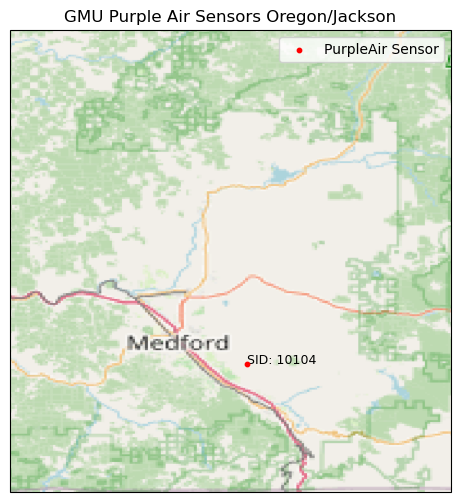

In [ ]:
# Create text boxes for user input
class AppData: # So the user doesn't have to re-enter the same data every time
    def __init__(self):
        # User states
        self.start_date = '01/01/2022' #TODO: remove this
        self.end_date = ''
        self.state = None
        self.county = None
        self.location = ''
        self.selected_sensors = ()

        # Data gathered from APIs
        self.sensor_data = None
        self.bounding_box = None

app_data = AppData() # Initialize data object

# Gather data widget code
start_date_box = widgets.Text(
    placeholder='dd/mm/yy',
    description='Date/Start Date:',
    disabled=False  
)

end_date_box = widgets.Text(
    placeholder='dd/mm/yy',
    description='End date:',
    disabled=False
)

state_dropdown = widgets.Dropdown(
    options=[(state[0], state[1]) for state in load_states()],
    value=41,
    description='State:',
    disabled=False,
)

county_dropdown = widgets.Dropdown(
    description='County:',
    options = load_counties(state_dropdown.value),
    value='Jackson',
    disabled=False,
)

gather_data_button = widgets.Button(
    description='Gather data',
    disabled=False,
    layout=widgets.Layout(width='auto'),
    tooltip='Gather data nescessary to plot statistics.',
)

def state_dropdown_change(e):
    county_dropdown.options = load_counties(state_dropdown.value)
    county_dropdown.value = county_dropdown.options[0]

def gather_data_button_click(e):
    # Widget state handling
    app_data.start_date = start_date_box.value
    app_data.end_date = end_date_box.value
    app_data.state = state_dropdown.value
    app_data.county = county_dropdown.value
    state_name = next((name for name, value in state_dropdown.options if value == state_dropdown.value), None)
    app_data.location = f'{state_name}/{county_dropdown.label}'
    clear_output()
    display_widgets('make_plot')

    # Gather data from APIs
    state, county = process_location(app_data.location)
    bounding_box = firealarm_processing.retrieve_bounding_box(state, county)
    sensor_data = firealarm_processing.retrieve_sensors(bounding_box, process_data(app_data.start_date))

    # Store data in app data so user can select which sensors they would like to plot and read data from.
    app_data.bounding_box = bounding_box
    app_data.sensor_data = [(data['latitude'], data['longitude'], data['platform_id']) for data in sensor_data]
    # Max SID len = 8, Max Latitude len = 10, Max Longitude len = 11
    sensor_select.options = [(f'Sensor ID: {str(data[2]) + " " * (8 - len(str(data[2])))}| Latitude: {data[0]} | Longitude: {data[1]}',
                              app_data.sensor_data.index(data)) for data in app_data.sensor_data]

state_dropdown.observe(state_dropdown_change, names='value')
gather_data_button.on_click(gather_data_button_click)

# Make plot widget code
sensor_select = widgets.SelectMultiple(
    layout=widgets.Layout(width='auto'),
    disabled=False
)

back_to_gather_data_button = widgets.Button(
    description='Back',
    disabled=False,
    layout=widgets.Layout(width='auto'),
    tooltip='Go back to the data gathering screen.',
)

make_plot_button = widgets.Button(
    description='Plot Selected Sensor(s)', # Multi Sensor data in future?
    disabled=False,
    layout=widgets.Layout(width='auto'),
    tooltip='Create a plot with data.',
)

def make_plot_button_click(e):
    app_data.selected_sensors = sensor_select.value
    clear_output()
    display_widgets('view_plot')
    state, county = process_location(app_data.location)
    plotting.map_points([app_data.sensor_data[i] for i in app_data.selected_sensors],
                        title=f'GMU Purple Air Sensors {state}/{county}', roads=True, bounds=app_data.bounding_box, legend=True)

def back_to_gather_data_button_click(e):
    clear_output()
    display_widgets('gather_data')

make_plot_button.on_click(make_plot_button_click)
back_to_gather_data_button.on_click(back_to_gather_data_button_click)

# View plot widget code
view_plot_home_button = widgets.Button(
    description='Home',
    disabled=False,
    layout=widgets.Layout(width='auto'),
    tooltip='Go back to the home screen.',
)

back_to_make_plot_button = widgets.Button(
    description='Back',
    disabled=False,
    layout=widgets.Layout(width='auto'),
    tooltip='Go back to the plot selection screen.',
)

def view_plot_home_button_click(e):
    clear_output()
    display_widgets('gather_data')

def back_to_make_plot_button_click(e):
    clear_output()
    display_widgets('make_plot')

view_plot_home_button.on_click(view_plot_home_button_click)
back_to_make_plot_button.on_click(back_to_make_plot_button_click)

def display_widgets(method):
    if method == 'gather_data':
        # Load options for county dropdown
        county_dropdown.options = load_counties(state_dropdown.value)

        # Load possible user states
        start_date_box.value = app_data.start_date
        end_date_box.value = app_data.end_date
        if app_data.state:
            state_dropdown.value = app_data.state

        if app_data.county:
            county_dropdown.value = app_data.county

        # Display widgets
        display(start_date_box)
        display(end_date_box)
        display(state_dropdown)
        display(county_dropdown)
        display(gather_data_button)

    elif method == 'make_plot':
        # Load possible user states
        sensor_select.value = app_data.selected_sensors

        # Display widgets
        display(widgets.Label('Sensors:'))
        display(widgets.Label('- To select a range of sensors: Click on the first sensor,'
                              'then hold \'Shift\' and click on the last sensor in the range.'))
        display(widgets.Label('- To select multiple individual sensors: Hold \'Ctrl\' (or '
                              '\'Cmd\' on Mac) and click on each sensor you want to select.'))
        display(sensor_select)
        display(make_plot_button)
        display(back_to_gather_data_button)

    elif method == 'view_plot':
        # Display widgets
        display(view_plot_home_button)
        display(back_to_make_plot_button)

display_widgets('gather_data')